### Understanding the Business Problem

TalkingData is a Chinese big data company, and one of their areas of expertise is mobile advertisements.

In mobile advertisements, click fraud is a major source of losses. Click fraud is the practice of repeatedly clicking on an advertisement hosted on a website with the intention of generating revenue for the host website or draining revenue from the advertiser.

In this case, TalkingData happens to be serving the advertisers (their clients). TalkingData cover a whopping approx. 70% of the active mobile devices in China, of which 90% are potentially fraudulent (i.e. the user is actually not going to download the app after clicking).

You can imagine the amount of money they can help clients save if they are able to predict whether a given click is fraudulent (or equivalently, whether a given click will result in a download).

Their current approach to solve this problem is that they've generated a blacklist of IP addresses - those IPs which produce lots of clicks, but never install any apps. Now, they want to try some advanced techniques to predict the probability of a click being genuine/fraud.

In this problem, we will use the features associated with clicks, such as IP address, operating system, device type, time of click etc. to predict the probability of a click being fraud.

### Understanding and Exploring the Data

The data contains observations of about 240 million clicks, and whether a given click resulted in a download or not (1/0).

On Kaggle, the data is split into train.csv and train_sample.csv (100,000 observations). We'll use the smaller train_sample.csv in this notebook for speed, though while training the model for Kaggle submissions, the full training data will obviously produce better results.

The detailed data dictionary is mentioned here:

- ip: ip address of click (numeric).
- app: app id for marketing (category).
- device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- os: os version id of user mobile phone (category)
- channel: channel id of mobile ad publisher (category)
- click_time: timestamp of click (UTC) (time)
- attributed_time: if user download the app for after clicking an ad, this is the time of the app download (time)
- is_attributed: the target that is to be predicted, indicating → whether a click leads to an app install (binary)

The testset differs with three columns:

- click_id reference for making predictions (additional column) (numeric)

Let's try finding some useful trends in the data.

### Load packages

Here we load the libraries and set few parameters

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables

%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression


import lightgbm as lgb
import gc # memory 
from datetime import datetime # train time checking

pd.set_option('display.max_columns', 100)

### Read the Data

In [ ]:
#trainset = pd.read_csv(r'C:\Users\19258\Desktop\Projects\proj_3_ad_fraud_detection\Ad_fraud_Data\train_sample.csv')
#testset = pd.read_csv(r'C:\Users\19258\Desktop\Projects\proj_3_ad_fraud_detection\Ad_fraud_Data\test.csv')

In [6]:
trainset.head(5)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [7]:
testset.head(5)

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


### Check the data 

#### Glimpse the data 

let's check the train and test set structure.

In [8]:
print("train -  rows:",trainset.shape[0]," columns:", trainset.shape[1])
print("test -  rows:",testset.shape[0]," columns:", testset.shape[1])

train -  rows: 100000  columns: 8
test -  rows: 18790469  columns: 7


In [9]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               100000 non-null  int64 
 1   app              100000 non-null  int64 
 2   device           100000 non-null  int64 
 3   os               100000 non-null  int64 
 4   channel          100000 non-null  int64 
 5   click_time       100000 non-null  object
 6   attributed_time  227 non-null     object
 7   is_attributed    100000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


In [10]:
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18790469 entries, 0 to 18790468
Data columns (total 7 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   click_id    int64 
 1   ip          int64 
 2   app         int64 
 3   device      int64 
 4   os          int64 
 5   channel     int64 
 6   click_time  object
dtypes: int64(6), object(1)
memory usage: 1003.5+ MB


#### Check missing data 

In [11]:
# Creating a table for missing values, unique values and data types of the features

missing_v_train = pd.DataFrame({'Feature': trainset.columns, '[TRAIN] No. of Missing Values': trainset.isnull().sum().values,
                                '[TRAIN] % of Missing Values': ((trainset.isnull().sum().values)/len(trainset)*100)})
missing_v_test = pd.DataFrame({'Feature': testset.columns, '[TEST] No. of Missing Values': testset.isnull().sum().values,
                                '[TEST] % of Missing Values': ((testset.isnull().sum().values)/len(testset)*100)})
unique_v = pd.DataFrame({'Feature':trainset.columns, 'No. of Unique Values[FROM TRAIN]':trainset.nunique().values})
feature_types = pd.DataFrame({'Feature':trainset.columns, 'DataType':trainset.dtypes})

merged = pd.merge(missing_v_train, missing_v_test, on='Feature', how='left')
merged = pd.merge(merged, unique_v, on='Feature', how='left')
merged = pd.merge(merged, feature_types, on='Feature', how='left')

merged.style.background_gradient(cmap='viridis')

,Feature,[TRAIN] No. of Missing Values,[TRAIN] % of Missing Values,[TEST] No. of Missing Values,[TEST] % of Missing Values,No. of Unique Values[FROM TRAIN],DataType
0,ip,0,0.000000,0.000000,0.000000,34857,int64
1,app,0,0.000000,0.000000,0.000000,161,int64
2,device,0,0.000000,0.000000,0.000000,100,int64
3,os,0,0.000000,0.000000,0.000000,130,int64
4,channel,0,0.000000,0.000000,0.000000,161,int64
5,click_time,0,0.000000,0.000000,0.000000,80350,object
6,attributed_time,99773,99.773000,nan,nan,227,object
7,is_attributed,0,0.000000,nan,nan,2,int64


In [12]:
len(trainset[trainset['is_attributed']==0])

99773

In [13]:
len(trainset[trainset['attributed_time'].isnull()])

99773

In [14]:
trainset[(trainset['is_attributed']==1) & (trainset['attributed_time'].isnull())]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed


The number of missing values in the attributed_time column exactly matches the number of rows where is_attributed = 0. In other words, whenever the app was not downloaded (is_attributed = 0), the corresponding attributed_time entry is missing.

🔹Why you can drop attributed_time

- Redundant information:
    attributed_time is completely determined by is_attributed:
    - If is_attributed = 0 → always NaN
    - If is_attributed = 1 → always filled (with a timestamp)
- So, for a classification task predicting is_attributed, attributed_time leaks the label.
- Keeping it could lead to data leakage (the model could trivially learn the target just from whether attributed_time is null).

In [15]:
trainset = trainset.drop('attributed_time', axis=1)

Only a very small part of the is_attributed data have 1 value (227 out of 100,000 values, 176,627 out of 75 M values). This means that the training dataset is highly imbalanced (0.23% have is_attributed = 1). Usually is used either undersample the records with is_attributed = 0 or oversample records with is_attributed = 1; because is a large dataset, it is a good option to do undersampling of records with is_attributed = 0.

🔹 Target (is_attributed):

- 1 → The click led to an app install (attributed → genuine conversion).
- 0 → The click did not lead to a conversion.

- Since advertisers only pay for installs, the competition treats “non-converting clicks” as the negative class (i.e., wasted or potentially fraudulent).

- So while the name is fraud detection, technically the prediction is conversion likelihood (will the click lead to an install). Fraud is the practical interpretation because many clicks come from bots or bad traffic that never converts.

🔹 Why Someone Said "Only 0.2% are fraudulent"

- In the training data, positive cases (is_attributed = 1) are extremely rare (~0.2%).
- That means 98–99% of rows are 0 (no install).
- From a fraud perspective:
    - Most clicks are “suspicious/low quality” → no installs.
    - Very few are genuine → installs happen.
So:
- From a business/advertiser perspective → this is fraud detection.
- From a machine learning perspective → this is a highly imbalanced classification problem (positive rate ~0.2%).

### EDA

#### Numerical Feature Analysis

🔹 Why it matters

1. If distributions match → your model can generalize better (train and test “come from the same population”).
2. If distributions are very different → you risk dataset shift (a.k.a. covariate shift). Your model may learn patterns that exist only in train but not in test (or vice versa).

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

def compare_distributions(train, test, cols, sample_size=200_000, bins=50):
    """
    Compare distributions of numerical features between train and test sets.
    
    Parameters
    ----------
    train : pd.DataFrame
        Training dataset
    test : pd.DataFrame
        Test dataset
    cols : list
        List of numerical columns to compare
    sample_size : int
        Subsample size to reduce memory (default: 200k)
    bins : int
        Number of bins for histograms
    """
    # Subsample to avoid memory issues
    if len(train) > sample_size:
        train = train.sample(sample_size, random_state=42)
    if len(test) > sample_size:
        test = test.sample(sample_size, random_state=42)

    for col in cols:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        
        # Histogram comparison
        sns.histplot(train[col], bins=bins, stat="density", 
                     color="blue", label="Train", element="step", ax=ax[0])
        sns.histplot(test[col], bins=bins, stat="density", 
                     color="orange", label="Test", element="step", ax=ax[0])
        ax[0].set_title(f"{col} - Histogram")
        ax[0].legend()

        # ECDF comparison
        sns.ecdfplot(train[col], color="blue", label="Train", ax=ax[1])
        sns.ecdfplot(test[col], color="orange", label="Test", ax=ax[1])
        ax[1].set_title(f"{col} - ECDF")
        ax[1].legend()

        plt.suptitle(f"Distribution comparison for {col}", fontsize=14)
        plt.tight_layout()
        plt.show()

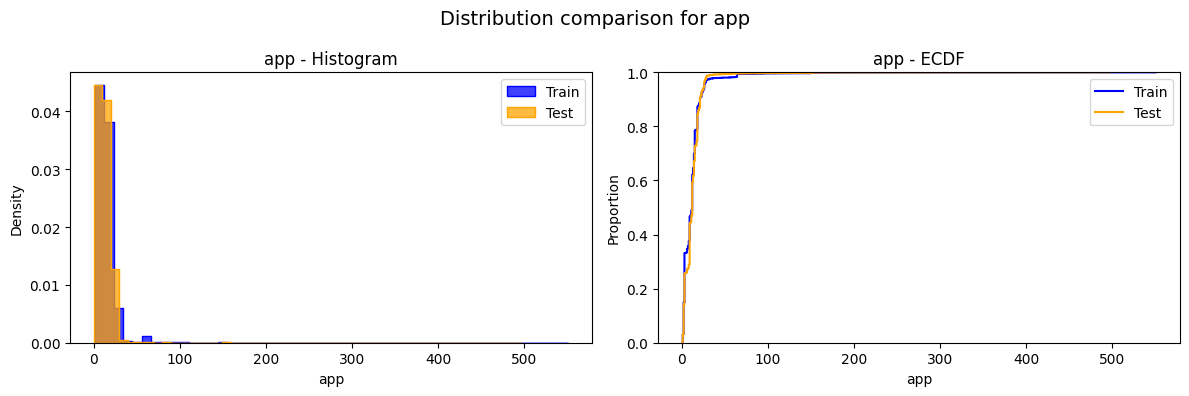

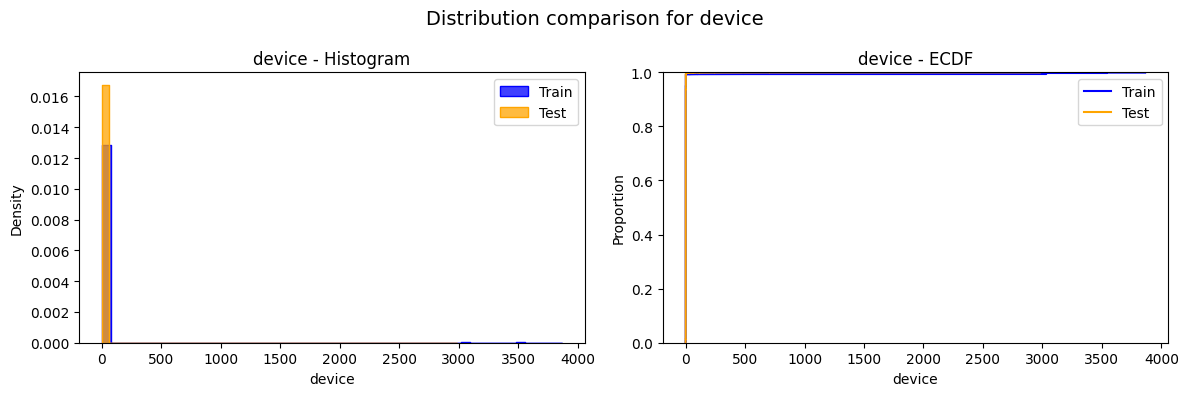

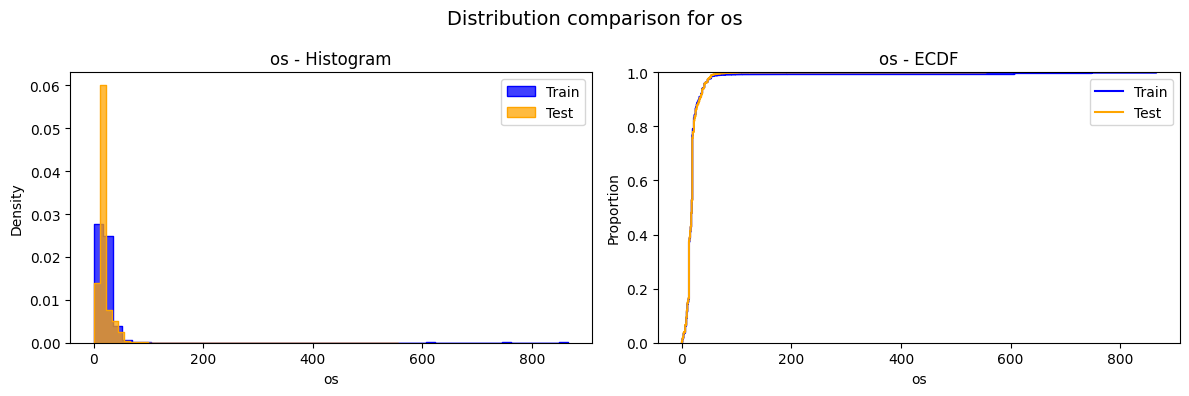

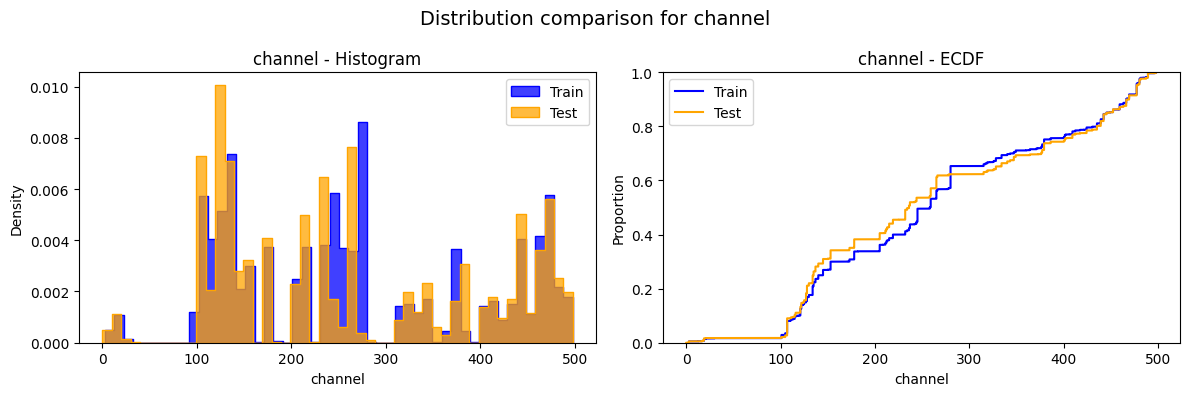

In [17]:
num_features = ['app','device','os','channel']  # or any other numeric columns
compare_distributions(trainset, testset, num_features)

**Insights**
1. Stable Features: app, os → distributions nearly identical across train/test. Safe to use directly.
2. Potential Issues: device, channel → mismatches and long tails. Could cause poor test performance.
    - Mitigation: frequency encoding, rare category bucketing, or dimensionality reduction.
3. General Takeaway:
    - Some features are stable across datasets (good generalization expected).
    - Others show covariate shift → must apply encoding/regularization or risk the model learning train-only patterns.

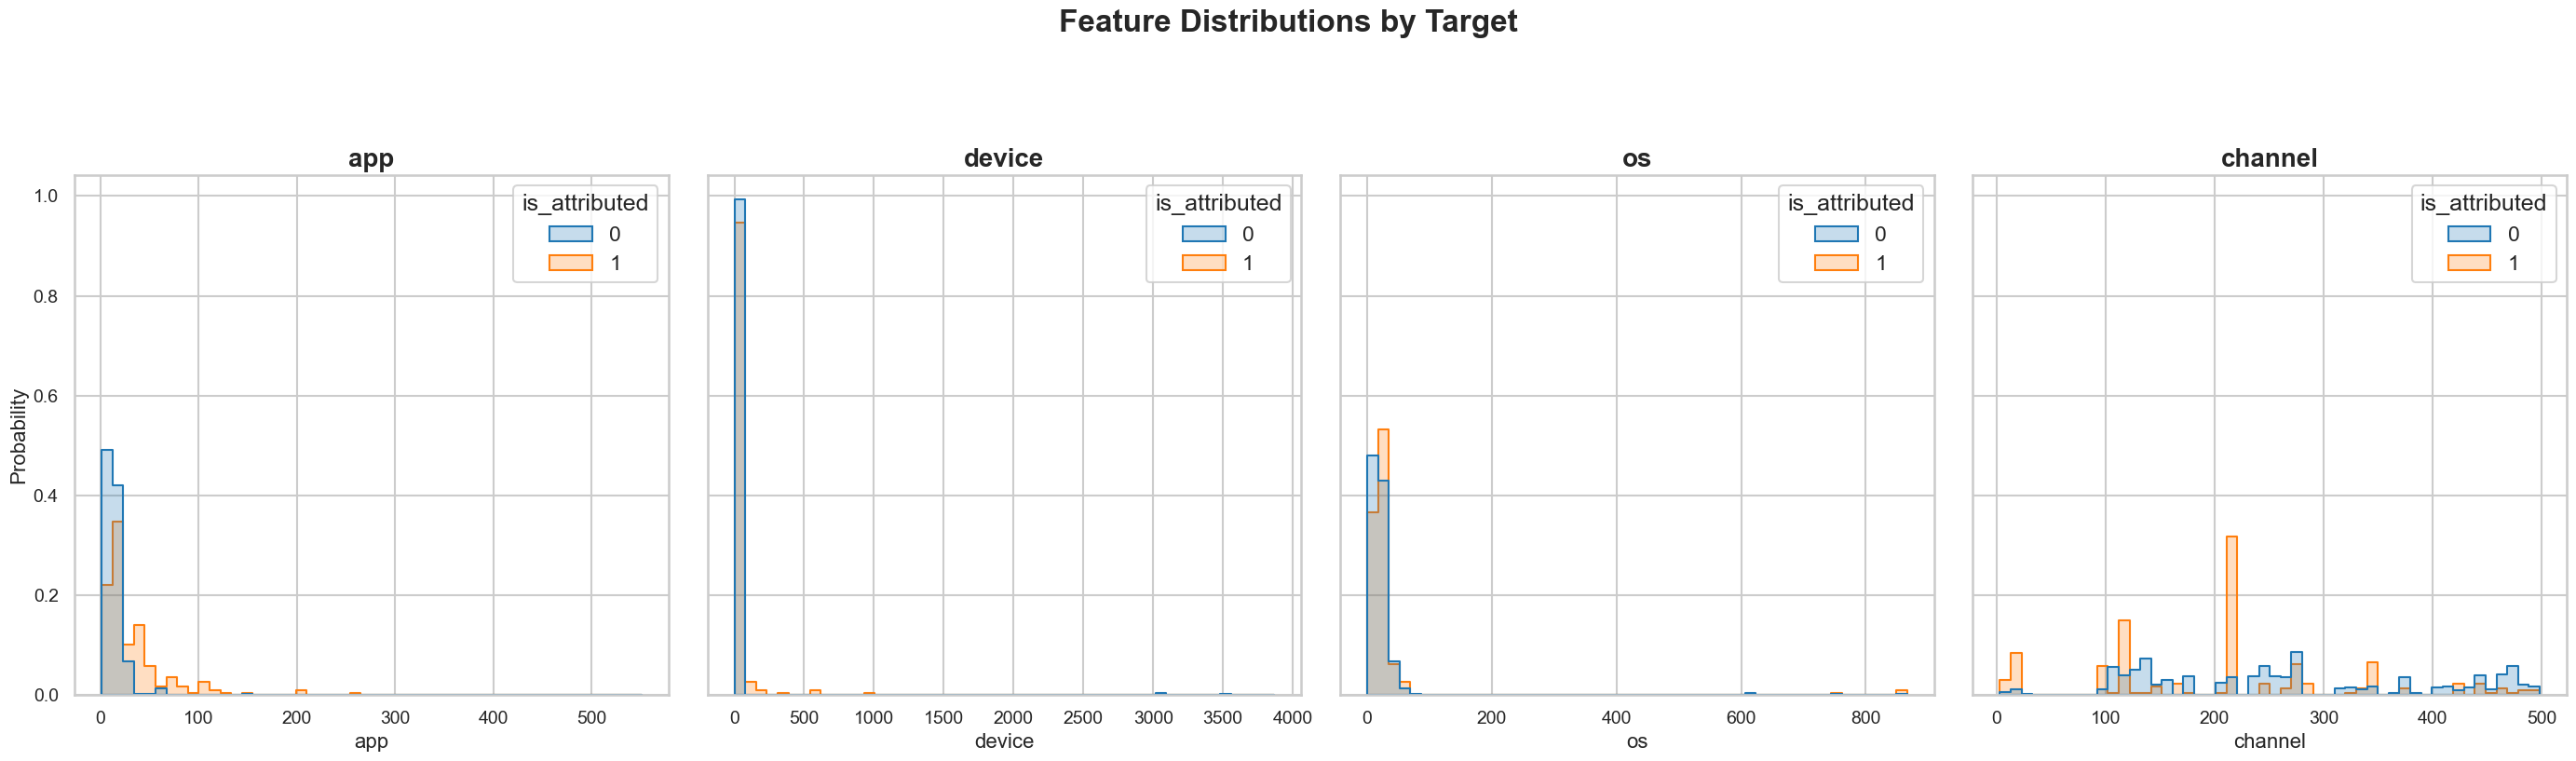

In [18]:


# Features to visualize
features = ['app', 'device', 'os', 'channel']

# Larger context for fonts
sns.set_style("whitegrid")
sns.set_context("talk")   # options: paper, notebook, talk, poster

fig, axes = plt.subplots(1, len(features), figsize=(28, 8), sharey=True)

for ax, feature in zip(axes, features):
    sns.histplot(data=trainset, x=feature, hue="is_attributed",
                 stat="probability", element="step", bins=50,
                 common_norm=False, ax=ax)
    ax.set_title(f"{feature}", fontsize=20, fontweight="bold")
    ax.set_xlabel(feature, fontsize=16)
    ax.set_ylabel("Probability", fontsize=16)
    ax.tick_params(axis='both', labelsize=14)

# Put legend once outside all plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2,
           frameon=False, fontsize=16)

plt.suptitle("Feature Distributions by Target", fontsize=24, fontweight="bold", y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle + legend
plt.show()

**Insights**

🔹 app

- Most conversions (is_attributed=1, orange) happen in the low app IDs range (0–50).
- The shape of positive vs negative is similar, but positives are slightly more concentrated in certain app IDs.
- ✅ Suggests that app ID is predictive, since some apps drive more downloads than others.

🔹 device

- Almost all traffic comes from a small cluster of device IDs at the low end (likely a “default” device).
- Conversions are also concentrated there → very limited variation.
- ✅ Insight: device ID adds little predictive power, because both positives and negatives come from the same dominant device(s).
- Might be worth dropping or only using it after frequency encoding.

🔹 os

- Like device, the vast majority of both positives and negatives are on low OS IDs.
- Very little separation between classes.
- ✅ Insight: os is not strongly discriminative — minimal impact unless interactions with other features are considered.

🔹 channel

- Some channels (e.g., around 200) show disproportionately high positive rates compared to negatives.
- ✅ This indicates channel is a strong predictor — certain publishers drive far more downloads than others.
- Suggests heavy class imbalance across channels, which the model can exploit.

✅ Overall Takeaways

1. Strong Predictors: app, channel — certain IDs clearly have higher conversion probabilities.
2. Weak Predictors: device, os — distributions are dominated by a single value, providing little separation.
3. Modeling Consideration:
    - For app and channel, consider frequency encoding or conversion rate encoding (target encoding) to capture predictive signal.
    - For device and os, you could drop them or keep them as weak signals (tree models will naturally downweight them).
4. Business Story:
“App and channel are the primary levers for conversions — specific apps and publishers strongly influence whether a click leads to a download. Device and OS, however, appear to contribute little beyond what’s already captured in other features.”

#### Target Feature Analysis

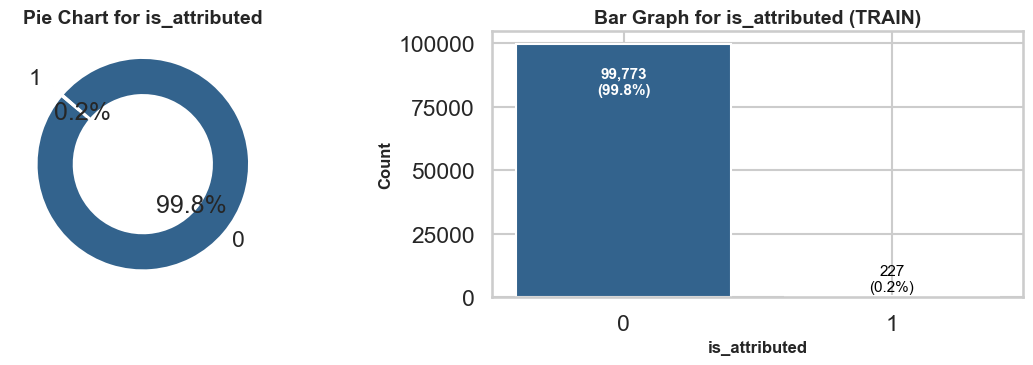

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


COLOR0 = '#33638d'
COLOR1 = '#ff9a0b'

def plot_target_distribution(df, target='is_attributed'):
    vc = df[target].value_counts().sort_index()
    pct = (vc / vc.sum() * 100).round(1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.set_style('whitegrid')

    # --- Pie (donut) ---
    axes[0].pie(
        vc.values,
        labels=vc.index.astype(str),
        autopct=lambda p: f"{p:.1f}%",
        startangle=140,
        colors=[COLOR0, COLOR1],
        wedgeprops=dict(width=0.35, edgecolor='white'),
        explode=[0.0, 0.15]  # highlight the tiny slice
    )
    axes[0].set_title(f"Pie Chart for {target}", fontsize=14, weight='bold')

    # --- Bar ---
    bars = axes[1].bar(vc.index.astype(str), vc.values, color=[COLOR0, COLOR1])
    axes[1].set_title(f"Bar Graph for {target} (TRAIN)", fontsize=14, weight='bold')
    axes[1].set_xlabel(target, fontsize=12, weight='bold')
    axes[1].set_ylabel("Count", fontsize=12, weight='bold')

    # Annotate bars smartly
    for bar, (cnt, p) in zip(bars, zip(vc.values, pct.values)):
        height = bar.get_height()
        if cnt > vc.max() * 0.5:   # big bar → put label *inside* the bar
            axes[1].text(
                bar.get_x() + bar.get_width()/2,
                height*0.85,  # inside bar
                f"{cnt:,}\n({p}%)",
                ha='center', va='center',
                fontsize=11, color="white", weight="bold"
            )
        else:  # small bar → above
            axes[1].text(
                bar.get_x() + bar.get_width()/2,
                height + vc.max()*0.01,  # just above
                f"{cnt:,}\n({p}%)",
                ha='center', va='bottom',
                fontsize=11, color="black"
            )

    plt.tight_layout()
    plt.show()

# Call it
plot_target_distribution(trainset, 'is_attributed')

🔹 Target (is_attributed):

- 1 → The click led to an app install (attributed → genuine conversion).
- 0 → The click did not lead to a conversion.

- Since advertisers only pay for installs, the competition treats “non-converting clicks” as the negative class (i.e., wasted or potentially fraudulent).

- So while the name is fraud detection, technically the prediction is conversion likelihood (will the click lead to an install). Fraud is the practical interpretation because many clicks come from bots or bad traffic that never converts.

🔹 Why Someone Said "Only 0.2% are fraudulent"

- In the training data, positive cases (is_attributed = 1) are extremely rare (~0.2%).
- That means 98–99% of rows are 0 (no install).
- From a fraud perspective:
    - Most clicks are “suspicious/low quality” → no installs.
    - Very few are genuine → installs happen.
So:
- From a business/advertiser perspective → this is fraud detection.
- From a machine learning perspective → this is a highly imbalanced classification problem (positive rate ~0.2%).

### Feature Engineering

#### Extract date and time data 

In [20]:
trainset['year'] = pd.to_datetime(trainset.click_time).dt.year
trainset['month'] = pd.to_datetime(trainset.click_time).dt.month
trainset['day'] = pd.to_datetime(trainset.click_time).dt.day
trainset['hour'] = pd.to_datetime(trainset.click_time).dt.hour
trainset['min'] = pd.to_datetime(trainset.click_time).dt.minute
trainset['sec'] = pd.to_datetime(trainset.click_time).dt.second
trainset.head()

,ip,app,device,os,channel,click_time,is_attributed,year,month,day,hour,min,sec
0,87540,12,1,13,497,2017-11-07 09:30:38,0,2017,11,7,9,30,38
1,105560,25,1,17,259,2017-11-07 13:40:27,0,2017,11,7,13,40,27
2,101424,12,1,19,212,2017-11-07 18:05:24,0,2017,11,7,18,5,24
3,94584,13,1,13,477,2017-11-07 04:58:08,0,2017,11,7,4,58,8
4,68413,12,1,1,178,2017-11-09 09:00:09,0,2017,11,9,9,0,9


In [21]:
date_vars = ['year', 'month', 'day', 'hour', 'min', 'sec']
for i in date_vars: 
    print(trainset[i].value_counts())

year
2017    100000
Name: count, dtype: int64
month
11    100000
Name: count, dtype: int64
day
8    34035
7    32393
9    28561
6     5011
Name: count, dtype: int64
hour
4     6039
0     5654
13    5619
14    5561
10    5511
5     5400
11    5342
12    5326
3     5264
2     5137
1     5103
7     5089
6     5079
15    4957
9     4867
8     4576
23    3870
16    3812
17    2176
22    2002
18    1183
19     870
21     864
20     699
Name: count, dtype: int64
min
0     1993
1     1819
33    1751
28    1736
2     1731
16    1730
32    1724
10    1723
13    1722
5     1719
7     1718
6     1713
43    1712
36    1711
20    1711
12    1702
24    1697
21    1694
14    1692
41    1682
52    1679
34    1678
15    1678
11    1675
8     1667
27    1666
18    1662
38    1659
22    1655
47    1654
54    1653
39    1650
37    1649
45    1648
56    1647
57    1645
23    1641
50    1638
17    1637
26    1637
48    1637
51    1635
53    1635
4     1632
29    1631
46    1629
9     1626
19    1622
3     16

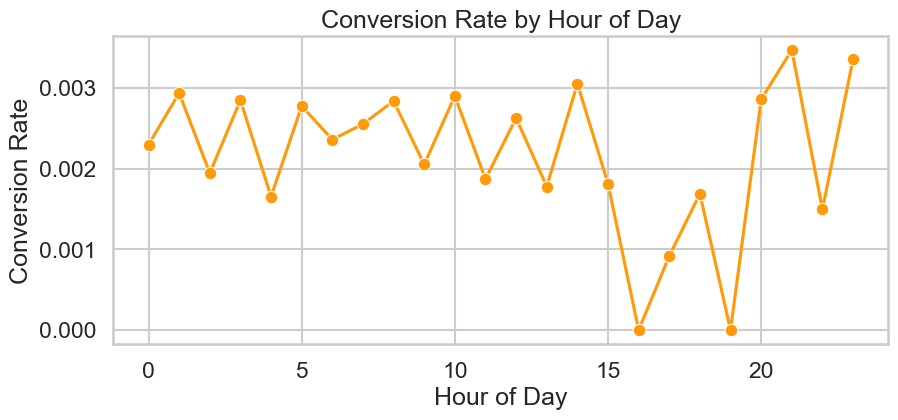

In [22]:
conv_rate = trainset.groupby("hour")["is_attributed"].mean()

plt.figure(figsize=(10,4))
sns.lineplot(x=conv_rate.index, y=conv_rate.values, marker="o", color="#ff9a0b")
plt.title("Conversion Rate by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Conversion Rate")
plt.show()

🔹 Key insights from your plot

1. Stable during daytime/early hours
    - Between ~0–15 hours (midnight to 3pm), conversion rates hover consistently between 0.2%–0.3%.
    - Suggests normal user behavior → people clicking and downloading in a fairly stable pattern.
2. Sharp dips around 16–19h (4–7pm)
- Conversion rates almost drop to zero in some hours.
- Possible explanation:
    - Bots or ad farms generating clicks but not downloads.
    - Data imbalance due to fewer positive labels at those hours.
    - A real user-behavior drop (e.g., evening commuting hours).
3. Spikes around 20–23h (8–11pm)
- Conversion rates jump back up, peaking around 0.35%+, higher than average.
- Suggests this is a prime time for genuine users to actually download apps after clicking ads.

🔹 Why this matters
- The hour of day is predictive:
    - Certain hours (evening) → more likely to convert.
    - Certain hours (late afternoon) → suspiciously low conversion, maybe bot-driven.
- A model can use this feature to distinguish between likely converters vs non-converters.
- From a fraud detection / anomaly detection perspective:
    - Hours with lots of clicks but almost zero downloads are red flags for non-human activity.

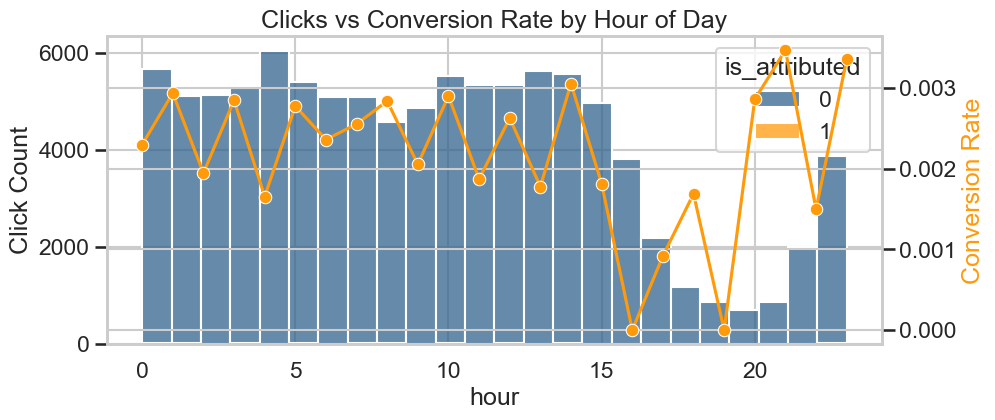

In [23]:
fig, ax1 = plt.subplots(figsize=(10,4))

# Count of clicks
sns.histplot(data=trainset, x="hour", hue="is_attributed",
             multiple="stack", bins=24, ax=ax1, palette=["#33638d","#ff9a0b"])
ax1.set_ylabel("Click Count")

# Conversion rate
ax2 = ax1.twinx()
sns.lineplot(x=conv_rate.index, y=conv_rate.values, marker="o", color="#ff9a0b", ax=ax2)
ax2.set_ylabel("Conversion Rate", color="#ff9a0b")

plt.title("Clicks vs Conversion Rate by Hour of Day")
plt.show()

🔹 Blue bars = click counts

    - From 0h–15h, click counts are fairly high (4k–6k).
    - At 16h–19h, blue bars drop a lot (down to ~1k–2k).
    - At 20h–23h, they pick up again somewhat (~2k–4k).

🔹 Orange line = conversion rate (installs / clicks)

    - Despite lower clicks at 16–19h, conversion rates also drop to nearly zero.
    - Normally, if click volume falls, conversion rate shouldn’t necessarily collapse — sometimes fewer clicks can even increase conversion rates if those clicks are higher quality.
    - But here, both click counts and conversion rates are low → that time window looks “dead” in terms of user engagement.

🔹 Corrected interpretation

    - 0h–15h (morning to afternoon) → Many clicks, stable conversion rate (~0.2–0.3%).
    - 16h–19h (late afternoon) → Fewer clicks and very low conversion rate → could mean people are busy (commuting, working), or it could reflect low-quality traffic.
    - 20h–23h (evening) → Clicks rise again and conversion rate spikes → people are more likely to install in the evening.

✅ Simplified takeaway

    - Conversion activity (installs) is time-dependent:
        - Stable in the morning/early afternoon,
        - Drops sharply late afternoon (16–19h),
        - Peaks in the evening (20–23h).
    - This pattern likely reflects real human behavior (busy hours vs free hours), but fraudulent traffic could still be a factor if conversions are disproportionately low compared to clicks.

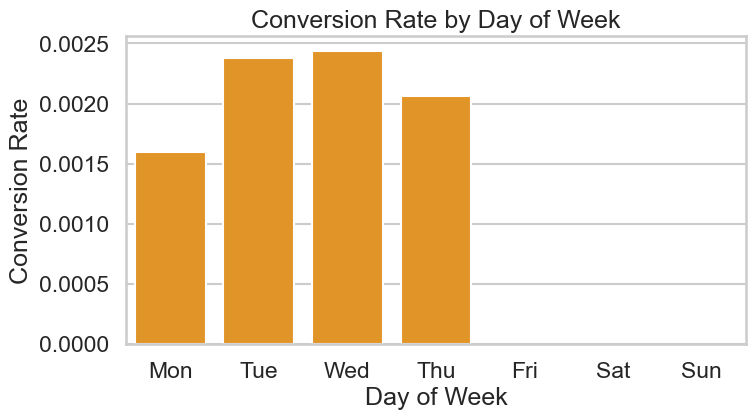

In [24]:
trainset['dayofweek'] = pd.to_datetime(trainset['click_time']).dt.dayofweek
day_map = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
trainset['day_name'] = trainset['dayofweek'].map(day_map)
# Compute conversion rate
conv_rate = trainset.groupby('day_name')['is_attributed'].mean().reindex(
    ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
)

plt.figure(figsize=(8,4))
sns.barplot(x=conv_rate.index, y=conv_rate.values, color='#ff9a0b')
plt.title("Conversion Rate by Day of Week")
plt.ylabel("Conversion Rate")
plt.xlabel("Day of Week")
plt.show()

🔹 Observations

    1. Higher conversion rates on Tue–Wed (~0.24%)
        - The conversion rate peaks mid-week, slightly above the average.
        - Suggests that users are more likely to follow through and install apps on these days.
    2. Lower conversion rate on Mon (~0.16%)
        - Early week performance is weaker. Possibly users are busier returning to routine and less likely to engage deeply after clicking ads.
    3. Slight dip on Thu (~0.20%)
        - Still positive, but slightly below Tue/Wed levels.
    4. No data for Fri–Sun
        - Bars are missing because your sample dataset seems to only cover Mon–Thu. In the full dataset, you’d expect some weekend behavior.

🔹 Interpretation

    - Mid-week (Tue–Wed) appears to be a sweet spot for conversions — clicks are more likely to lead to actual installs.
    - Start of week (Mon) shows weaker engagement → perhaps more casual/bot-like clicks or just lower user motivation.
    - Thu begins to decline, but still above Monday.
    - The missing Fri–Sun data means we can’t judge weekends here, but typically in ad data weekends can behave differently (sometimes higher due to free time, sometimes lower depending on app type).

In [25]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ip             100000 non-null  int64 
 1   app            100000 non-null  int64 
 2   device         100000 non-null  int64 
 3   os             100000 non-null  int64 
 4   channel        100000 non-null  int64 
 5   click_time     100000 non-null  object
 6   is_attributed  100000 non-null  int64 
 7   year           100000 non-null  int32 
 8   month          100000 non-null  int32 
 9   day            100000 non-null  int32 
 10  hour           100000 non-null  int32 
 11  min            100000 non-null  int32 
 12  sec            100000 non-null  int32 
 13  dayofweek      100000 non-null  int32 
 14  day_name       100000 non-null  object
dtypes: int32(7), int64(6), object(2)
memory usage: 8.8+ MB


In [26]:
trainset.dayofweek.value_counts()

dayofweek
2    34035
1    32393
3    28561
0     5011
Name: count, dtype: int64

#### Additional Feature Engineering 

##### Train

In [27]:
import pandas as pd
from typing import List, Optional

def add_count(
    df: pd.DataFrame,
    by: list[str],
    name: str,
    dtype: str = "uint32",
    fillna_value: int = 0
) -> pd.DataFrame:
    """
    Count rows per group, including groups with NaN in keys.
    """
    # include NaN as a valid key to avoid missing rows
    grp = df.groupby(by, dropna=False, sort=False)
    df[name] = grp.transform("size")

    # fill any residual NaNs defensively and cast
    # (shouldn't happen with dropna=False, but keeps things safe if you later map from train->test)
    df[name] = df[name].fillna(fillna_value).astype(dtype)
    return df

In [28]:
# counts
add_count(trainset, by=["ip", "day", "hour"], name="ip_tcount")
add_count(trainset, by=["ip", "app"], name="ip_app_count")
add_count(trainset, by=["ip", "app", "os"], name="ip_app_os_count", dtype="uint16")

,ip,app,device,os,channel,click_time,is_attributed,year,month,day,hour,min,sec,dayofweek,day_name,ip_tcount,ip_app_count,ip_app_os_count
0,87540,12,1,13,497,2017-11-07 09:30:38,0,2017,11,7,9,30,38,1,Tue,1,3,2
1,105560,25,1,17,259,2017-11-07 13:40:27,0,2017,11,7,13,40,27,1,Tue,4,4,1
2,101424,12,1,19,212,2017-11-07 18:05:24,0,2017,11,7,18,5,24,1,Tue,1,1,1
3,94584,13,1,13,477,2017-11-07 04:58:08,0,2017,11,7,4,58,8,1,Tue,1,1,1
4,68413,12,1,1,178,2017-11-09 09:00:09,0,2017,11,9,9,0,9,3,Thu,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,124883,11,1,19,122,2017-11-09 13:25:41,0,2017,11,9,13,25,41,3,Thu,1,1,1
99996,85150,9,1,13,244,2017-11-07 11:25:43,0,2017,11,7,11,25,43,1,Tue,1,2,1
99997,18839,3,1,13,19,2017-11-08 11:38:42,0,2017,11,8,11,38,42,2,Wed,1,2,1
99998,114276,15,1,12,245,2017-11-08 17:55:21,0,2017,11,8,17,55,21,2,Wed,2,20,1


In [29]:
def add_nunique(
    df: pd.DataFrame,
    by: List[str],
    col: str,
    name: str,
    dtype: str = "uint32"
) -> pd.DataFrame:
    """
    Add a column with the number of UNIQUE values of `col` per group.

    Example:
        add_nunique(trainset, by=["ip"], col="app", name="ip_unique_apps")
        -> for each row, how many distinct apps that ip has clicked

    Parameters
    ----------
    df : DataFrame
        Input dataframe (modified in place and also returned).
    by : list of str
        Column(s) to group by.
    col : str
        Column for which to count unique values.
    name : str
        Name of the new unique-count column.
    dtype : str
        Integer dtype to cast to.

    Returns
    -------
    DataFrame
        Same df with a new column `name`.
    """
    df[name] = df.groupby(by)[col].transform("nunique").astype(dtype)
    return df

In [30]:
# unique counts
add_nunique(trainset, by=["ip"], col="channel", name="X0", dtype="uint8")
add_nunique(trainset, by=["ip", "day"], col="hour", name="X2", dtype="uint8")
add_nunique(trainset, by=["ip"], col="app", name="X3", dtype="uint8")
add_nunique(trainset, by=["ip", "app"], col="os", name="X4", dtype="uint8")
add_nunique(trainset, by=["ip"], col="device", name="X5", dtype="uint16")
add_nunique(trainset, by=["app"], col="channel", name="X6")
add_nunique(trainset, by=["ip", "device", "os"], col="app", name="X8")

,ip,app,device,os,channel,click_time,is_attributed,year,month,day,hour,min,sec,dayofweek,day_name,ip_tcount,ip_app_count,ip_app_os_count,X0,X2,X3,X4,X5,X6,X8
0,87540,12,1,13,497,2017-11-07 09:30:38,0,2017,11,7,9,30,38,1,Tue,1,3,2,6,6,4,2,1,26,2
1,105560,25,1,17,259,2017-11-07 13:40:27,0,2017,11,7,13,40,27,1,Tue,4,4,1,54,23,23,3,3,1,7
2,101424,12,1,19,212,2017-11-07 18:05:24,0,2017,11,7,18,5,24,1,Tue,1,1,1,2,1,2,1,1,26,2
3,94584,13,1,13,477,2017-11-07 04:58:08,0,2017,11,7,4,58,8,1,Tue,1,1,1,3,1,3,1,1,6,1
4,68413,12,1,1,178,2017-11-09 09:00:09,0,2017,11,9,9,0,9,3,Thu,1,2,1,4,1,3,2,1,26,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,124883,11,1,19,122,2017-11-09 13:25:41,0,2017,11,9,13,25,41,3,Thu,1,1,1,4,5,4,1,1,12,2
99996,85150,9,1,13,244,2017-11-07 11:25:43,0,2017,11,7,11,25,43,1,Tue,1,2,1,9,3,8,2,2,29,2
99997,18839,3,1,13,19,2017-11-08 11:38:42,0,2017,11,8,11,38,42,2,Wed,1,2,1,4,3,3,2,1,32,1
99998,114276,15,1,12,245,2017-11-08 17:55:21,0,2017,11,8,17,55,21,2,Wed,2,20,1,62,20,29,10,7,24,2


In [31]:
def add_cumcount(
    df: pd.DataFrame,
    by: List[str],
    col: str,
    name: str,
    dtype: str = "uint32",
    sort_by: Optional[str] = None,
    ascending: bool = True
) -> pd.DataFrame:
    """
    Add a column with the CUMULATIVE COUNT (0,1,2,...) of `col` within each group.

    Example:
        add_cumcount(trainset, by=["ip", "device", "os"], col="app", name="seq_click_idx")
        -> within each (ip, device, os) group, label each row with its running index

    Tip:
        If you want cumcount to reflect time order, pass `sort_by="click_time"`
        (or another timestamp column). This function will temporarily sort and
        then restore the original order.

    Parameters
    ----------
    df : DataFrame
        Input dataframe (modified in place and also returned).
    by : list of str
        Column(s) to group by.
    col : str
        Column used only to anchor the group for cumcount.
        (cumcount ignores the values and just numbers rows in each group)
    name : str
        Name of the new cumulative-count column.
    dtype : str
        Integer dtype to cast to.
    sort_by : Optional[str]
        Column to sort by BEFORE computing cumcount, e.g., a timestamp.
        If None, use the current row order.
    ascending : bool
        Sort ascending if sort_by is provided.

    Returns
    -------
    DataFrame
        Same df with a new column `name`.
    """
    if sort_by is None:
        # No sorting: use current order
        df[name] = df.groupby(by)[col].cumcount().astype(dtype)
        return df
    else:
        # Sort, compute, then restore original order
        original_index = df.index
        df_sorted = df.sort_values(sort_by, ascending=ascending).copy()
        df_sorted[name] = df_sorted.groupby(by)[col].cumcount().astype(dtype)
        # Put values back in original order
        df.loc[df_sorted.index, name] = df_sorted[name]
        # Ensure dtype
        df[name] = df[name].astype(dtype)
        df = df.loc[original_index]
        return df

In [32]:
# cumulative counts (optionally sort by time if you kept it)
add_cumcount(trainset, by=["ip", "device", "os"], col="app", name="X1")
add_cumcount(trainset, by=["ip"], col="os", name="X7")


,ip,app,device,os,channel,click_time,is_attributed,year,month,day,hour,min,sec,dayofweek,day_name,ip_tcount,ip_app_count,ip_app_os_count,X0,X2,X3,X4,X5,X6,X8,X1,X7
0,87540,12,1,13,497,2017-11-07 09:30:38,0,2017,11,7,9,30,38,1,Tue,1,3,2,6,6,4,2,1,26,2,0,0
1,105560,25,1,17,259,2017-11-07 13:40:27,0,2017,11,7,13,40,27,1,Tue,4,4,1,54,23,23,3,3,1,7,0,0
2,101424,12,1,19,212,2017-11-07 18:05:24,0,2017,11,7,18,5,24,1,Tue,1,1,1,2,1,2,1,1,26,2,0,0
3,94584,13,1,13,477,2017-11-07 04:58:08,0,2017,11,7,4,58,8,1,Tue,1,1,1,3,1,3,1,1,6,1,0,0
4,68413,12,1,1,178,2017-11-09 09:00:09,0,2017,11,9,9,0,9,3,Thu,1,2,1,4,1,3,2,1,26,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,124883,11,1,19,122,2017-11-09 13:25:41,0,2017,11,9,13,25,41,3,Thu,1,1,1,4,5,4,1,1,12,2,1,4
99996,85150,9,1,13,244,2017-11-07 11:25:43,0,2017,11,7,11,25,43,1,Tue,1,2,1,9,3,8,2,2,29,2,1,13
99997,18839,3,1,13,19,2017-11-08 11:38:42,0,2017,11,8,11,38,42,2,Wed,1,2,1,4,3,3,2,1,32,1,0,3
99998,114276,15,1,12,245,2017-11-08 17:55:21,0,2017,11,8,17,55,21,2,Wed,2,20,1,62,20,29,10,7,24,2,1,218


🔹 1. Raw IDs are meaningless to models

    - Columns like ip=123456 or app=17 are just labels — they don’t carry numeric meaning.
    - Tree models (like XGBoost/LightGBM) can use them if encoded, but they can’t directly capture behavioral patterns.
    - Example: Knowing that ip=111 doesn’t mean much unless we also know how that IP behaves.

🔹 2. Counts = activity volume

    - A single IP making 10,000 clicks is very different from one making 3 clicks.
    - Bots tend to generate huge volumes of clicks; real users don’t.
    - Adding count features helps the model pick up that difference.
    ✅ The model learns: “High click counts from an IP = lower probability of install.”

🔹 3. Unique counts = diversity of behavior

    - Real users usually click on different apps/channels/devices.
    - Bots often click repeatedly on the same app/channel.
    - Unique count features encode this variety.
    ✅ The model learns: “IPs with low diversity (e.g., only 1 app across 1000 clicks) are suspicious.”

🔹 4. Cumulative counts = temporal patterns

    - Fraudulent traffic often happens in bursts (many clicks in a few seconds).
    - Cumulative counts show the order of events within a group (like IP or device).
    ✅ The model learns: “If an IP’s 50th click happened within a minute, that’s bot-like.”

🔹 5. They make the problem “learnable”

    - Without these engineered features, your model only sees:
    - ip=12345, app=17, channel=2, os=3, device=1
    - That’s almost meaningless.
    - With features like:
        - ip_click_count=5000, ip_unique_apps=1, ip_day_unique_hours=1, ip_app_cumcount=200
    - Now the model sees behavior:
        - Heavy clicker,
        - Low variety,
        - Always active at the same hour,
        - 200th click in a sequence.
    That’s a much clearer signal for classification (is_attributed = 0 vs 1).

In [33]:
def add_group_mean(df, by, col, name, past_only=False, time_col=None, dtype="float32"):
    if past_only:
        assert time_col is not None, "past_only=True requires time_col"
        df = df.sort_values(time_col)
        g = df.groupby(by)[col].apply(lambda s: s.shift().expanding().mean())
        df[name] = g.values.astype(dtype)
        df = df.sort_index()
    else:
        df[name] = df.groupby(by)[col].transform("mean").astype(dtype)
    return df

def add_group_var(df, by, col, name, past_only=False, time_col=None, dtype="float32"):
    s = pd.to_numeric(df[col], errors="coerce")
    if past_only:
        assert time_col is not None, "past_only=True requires time_col"
        df_sorted = df.sort_values(time_col).copy()
        g = df_sorted.groupby(by)[col].apply(lambda x: x.shift().expanding().var(ddof=0))
        df[name] = g.values.astype(dtype)
        df.sort_index(inplace=True)
    else:
        # ddof=0 makes 1-row groups → variance 0 (not NaN)
        df[name] = df.groupby(by)[col].transform(lambda x: x.var(ddof=0)).astype(dtype)
    return df

In [34]:
add_group_var(trainset,  by=['ip','day','channel'],     col='hour', name='ip_tchan_count')
add_group_var(trainset,  by=['ip','app','os'],          col='hour', name='ip_app_os_var')
add_group_var(trainset,  by=['ip','app','channel'],     col='day',  name='ip_app_channel_var_day')
add_group_mean(trainset, by=['ip','app','channel'],     col='hour', name='ip_app_channel_mean_hour')

,ip,app,device,os,channel,click_time,is_attributed,year,month,day,hour,min,sec,dayofweek,day_name,ip_tcount,ip_app_count,ip_app_os_count,X0,X2,X3,X4,X5,X6,X8,X1,X7,ip_tchan_count,ip_app_os_var,ip_app_channel_var_day,ip_app_channel_mean_hour
0,87540,12,1,13,497,2017-11-07 09:30:38,0,2017,11,7,9,30,38,1,Tue,1,3,2,6,6,4,2,1,26,2,0,0,0.000000,12.25,0.000000,9.000000
1,105560,25,1,17,259,2017-11-07 13:40:27,0,2017,11,7,13,40,27,1,Tue,4,4,1,54,23,23,3,3,1,7,0,0,12.666667,0.00,0.187500,11.500000
2,101424,12,1,19,212,2017-11-07 18:05:24,0,2017,11,7,18,5,24,1,Tue,1,1,1,2,1,2,1,1,26,2,0,0,0.000000,0.00,0.000000,18.000000
3,94584,13,1,13,477,2017-11-07 04:58:08,0,2017,11,7,4,58,8,1,Tue,1,1,1,3,1,3,1,1,6,1,0,0,0.000000,0.00,0.000000,4.000000
4,68413,12,1,1,178,2017-11-09 09:00:09,0,2017,11,9,9,0,9,3,Thu,1,2,1,4,1,3,2,1,26,1,0,0,0.000000,0.00,0.000000,9.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,124883,11,1,19,122,2017-11-09 13:25:41,0,2017,11,9,13,25,41,3,Thu,1,1,1,4,5,4,1,1,12,2,1,4,0.000000,0.00,0.000000,13.000000
99996,85150,9,1,13,244,2017-11-07 11:25:43,0,2017,11,7,11,25,43,1,Tue,1,2,1,9,3,8,2,2,29,2,1,13,0.000000,0.00,0.000000,11.000000
99997,18839,3,1,13,19,2017-11-08 11:38:42,0,2017,11,8,11,38,42,2,Wed,1,2,1,4,3,3,2,1,32,1,0,3,0.000000,0.00,0.000000,11.000000
99998,114276,15,1,12,245,2017-11-08 17:55:21,0,2017,11,8,17,55,21,2,Wed,2,20,1,62,20,29,10,7,24,2,1,218,24.687500,0.00,0.617284,10.000000


✅ What each one means (intuition)

- ip_tchan_count = var(hour | ip, day, channel)
For a given (ip, day, channel), how spread out are the click hours?
    - Low variance → clicks happen at the same hour → bot-like or scripted.
    - Higher variance → clicks scattered across hours → more human-like.

- ip_app_os_var = var(hour | ip, app, os)
For an IP interacting with a specific app on a specific OS, how variable are the hours?
    - Captures routine vs randomness of behavior for that triplet.

- ip_app_channel_var_day = var(day | ip, app, channel)
Across days, how irregular is the activity for the same (ip, app, channel)?
    - Low variance → bursts on the same day(s).
    - Higher variance → activity distributed across multiple days.

- ip_app_channel_mean_hour = mean(hour | ip, app, channel)
The “typical” hour for interactions on that (ip, app, channel) path.
    - Channels that skew to odd hours for a given IP/app can be suspicious.

These features convert raw IDs into behavioral fingerprints, which makes it possible for a classifier to separate real users (low counts, high diversity, irregular patterns) from fraudulent traffic (high counts, low diversity, repetitive/burst patterns).

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_feature_distributions(
    df, features, nrows=2, ncols=4, title="Feature Distributions by Target",
    legend_loc="bottom"
):
    # Split by target
    t1 = df[df['is_attributed'] == 1]
    t0 = df[df['is_attributed'] == 0]

    sns.set_style("whitegrid")
    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10))
    axes = axes.flatten()

    # Plot without per-axes legends
    for i, feature in enumerate(features):
        ax = axes[i]
        sns.kdeplot(t1[feature], bw_adjust=0.5, ax=ax, legend=False, label=None)
        sns.kdeplot(t0[feature], bw_adjust=0.5, ax=ax, legend=False, label=None)
        ax.set_title(feature, fontsize=12)
        ax.set_xlabel("")
        ax.set_ylabel("Density plot")
        ax.tick_params(axis="both", which="major", labelsize=10)

    # Remove empty axes if any
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axes[j])

    # Figure-level legend (custom handles so seaborn doesn’t add per-axes ones)
    handles = [
        Line2D([0], [0], color=sns.color_palette()[0], lw=2, label="is_attributed = 1"),
        Line2D([0], [0], color=sns.color_palette()[1], lw=2, label="is_attributed = 0"),
    ]

    if legend_loc == "top":
        fig.legend(handles=handles, loc="upper center", ncol=2, frameon=False, fontsize=12,
                   bbox_to_anchor=(0.5, 1.02))
        fig.suptitle(title, fontsize=16, y=0.98)
        plt.subplots_adjust(top=0.88, hspace=0.35, wspace=0.28)
    else:  # bottom
        fig.legend(handles=handles, loc="lower center", ncol=2, frameon=False, fontsize=12,
                   bbox_to_anchor=(0.5, -0.02))
        fig.suptitle(title, fontsize=16, y=0.98)
        plt.subplots_adjust(top=0.9, bottom=0.12, hspace=0.35, wspace=0.28)

    plt.show()

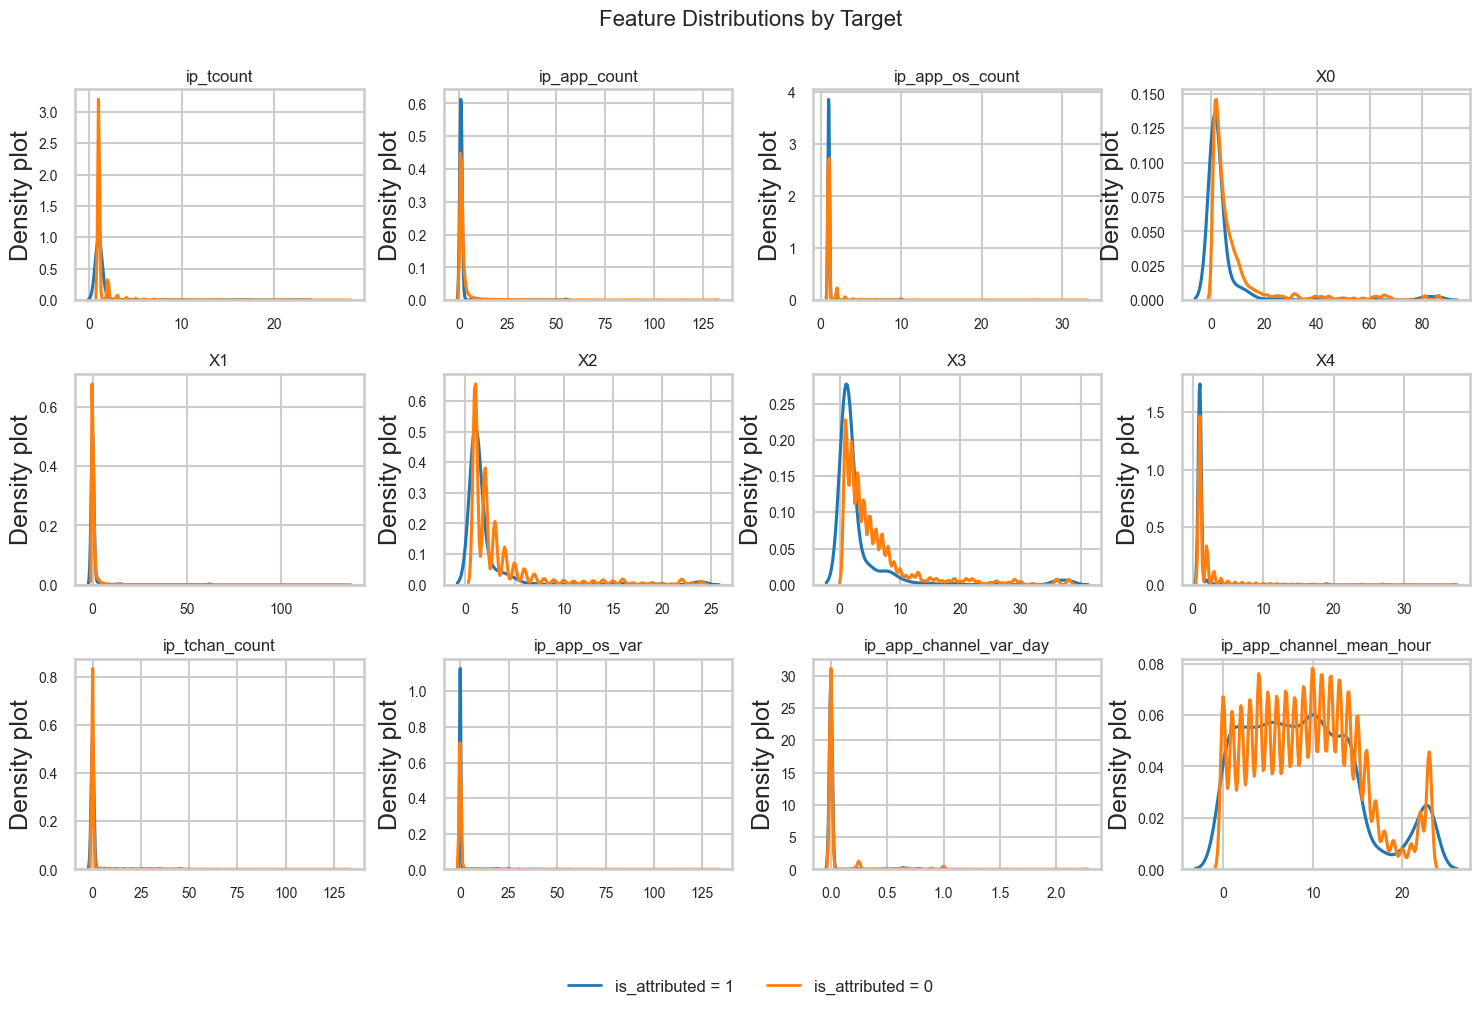

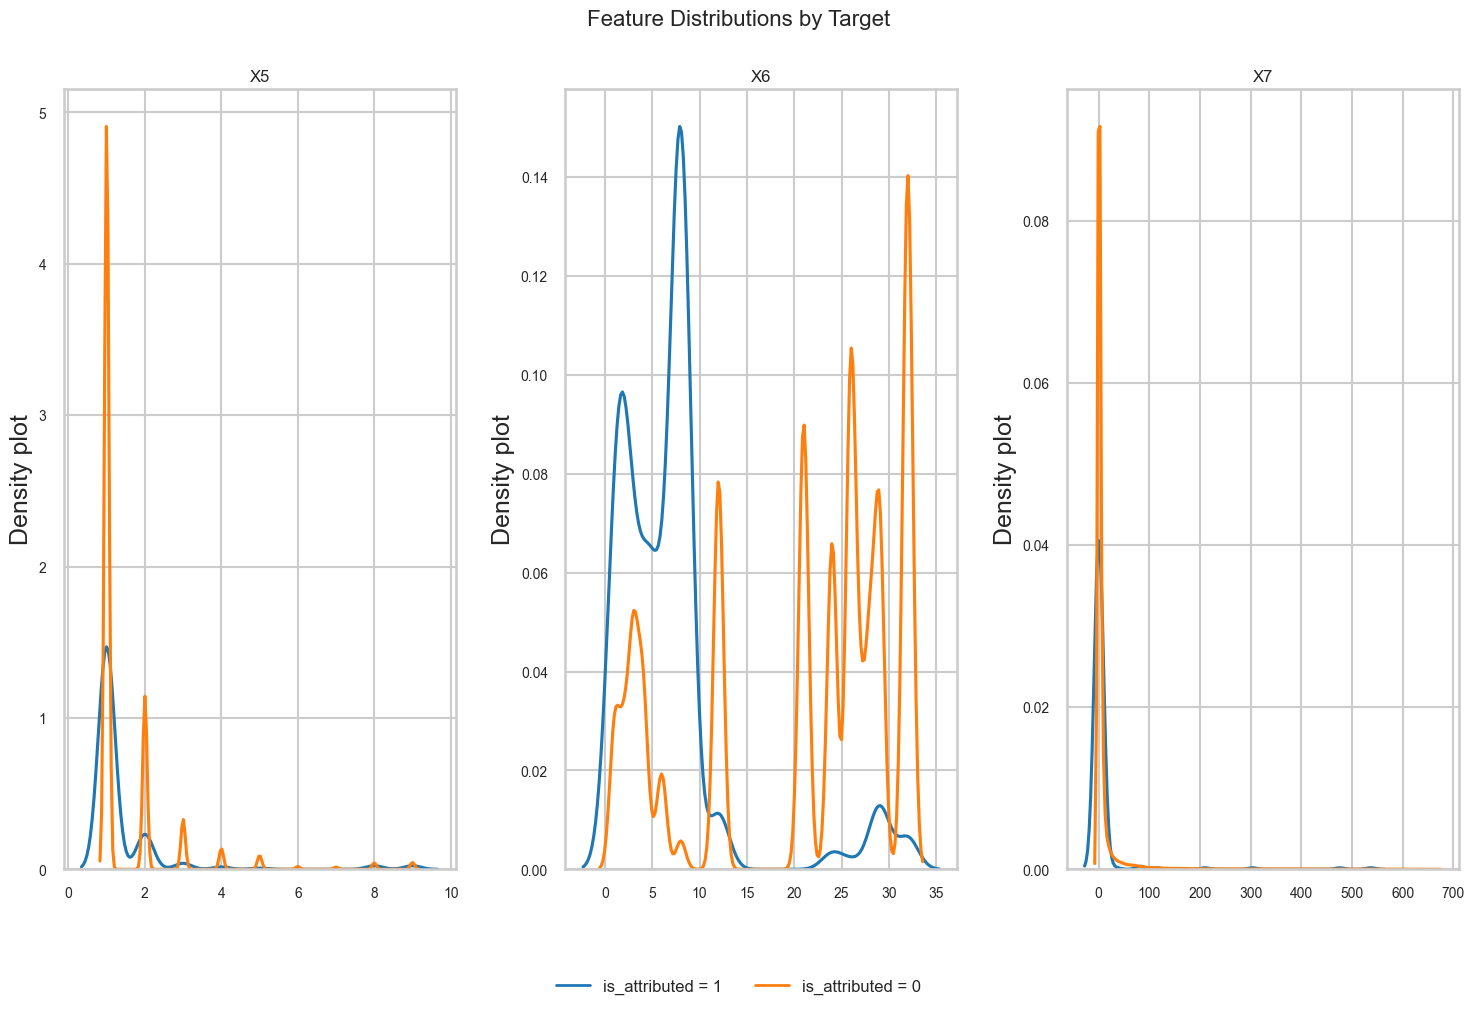

In [36]:
batch1 = ["ip_tcount","ip_app_count","ip_app_os_count","X0","X1","X2","X3","X4",'ip_tchan_count','ip_app_os_var','ip_app_channel_var_day','ip_app_channel_mean_hour']
batch2 = ["X5","X6","X7"]

plot_feature_distributions(trainset, batch1, nrows=3, ncols=4, legend_loc="bottom")
plot_feature_distributions(trainset, batch2, nrows=1, ncols=3, legend_loc="bottom")


✅ Most useful features (good separation)

These show clear differences between converters (is_attributed=1) and non-converters (is_attributed=0):

    - X1 (cumulative app count per ip-device-os)
        - Non-converters extend far to the right (many repeated app interactions).
        - Converters stay concentrated near 0.
        - 👉 Strong signal: bots repeatedly click across apps, real users don’t.

    - X5 (unique devices per IP)
        - Converters almost always tied to 1 device.
        - Non-converters often tied to 2+ devices.
        - 👉 Strong indicator: multiple devices per IP looks suspicious.

    - X6 (unique channels per app)
        - Converters cluster in certain ranges, non-converters spread noisily.
        - 👉 Useful for detecting unnatural promotion activity.

    - ip_app_os_var (variance of click hour per ip-app-os)
        - Converters show low variance (predictable usage).
        - Non-converters show higher spikes, meaning “always-on” bot activity.
        - 👉 Very good separation.

❌ Less useful features (heavy overlap)

These show almost identical distributions for converters vs non-converters, so they won’t help much:

    - X0 (unique channels per IP)
    - X2 (unique hours per ip-day)
    - X3 (unique apps per IP)
    - X4 (unique OS per ip-app)
    - X7 (cumulative OS count per IP)

👉 Their curves overlap almost entirely — little to no predictive power on their own.

In [37]:
trainset = trainset.drop(['X0', 'X2', 'X3', 'X4', 'X7'], axis = 1)

In [38]:
trainset.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed',
       'year', 'month', 'day', 'hour', 'min', 'sec', 'dayofweek', 'day_name',
       'ip_tcount', 'ip_app_count', 'ip_app_os_count', 'X5', 'X6', 'X8', 'X1',
       'ip_tchan_count', 'ip_app_os_var', 'ip_app_channel_var_day',
       'ip_app_channel_mean_hour'],
      dtype='object')

##### Test

Let's continue with the data on time. First we will have to do the date and time extraction operation on testset data.

In [39]:
testset['year'] = pd.to_datetime(testset.click_time).dt.year
testset['month'] = pd.to_datetime(testset.click_time).dt.month
testset['day'] = pd.to_datetime(testset.click_time).dt.day
testset['hour'] = pd.to_datetime(testset.click_time).dt.hour
testset['min'] = pd.to_datetime(testset.click_time).dt.minute
testset['sec'] = pd.to_datetime(testset.click_time).dt.second
testset.head()

,click_id,ip,app,device,os,channel,click_time,year,month,day,hour,min,sec
0,0,5744,9,1,3,107,2017-11-10 04:00:00,2017,11,10,4,0,0
1,1,119901,9,1,3,466,2017-11-10 04:00:00,2017,11,10,4,0,0
2,2,72287,21,1,19,128,2017-11-10 04:00:00,2017,11,10,4,0,0
3,3,78477,15,1,13,111,2017-11-10 04:00:00,2017,11,10,4,0,0
4,4,123080,12,1,13,328,2017-11-10 04:00:00,2017,11,10,4,0,0


In [40]:
trainset.day.value_counts()

day
8    34035
7    32393
9    28561
6     5011
Name: count, dtype: int64

In [41]:
testset.day.value_counts()

day
10    18790469
Name: count, dtype: int64

In [42]:
def add_count(
    df: pd.DataFrame,
    by: List[str],
    name: str,
    dtype: str = "uint32"
) -> pd.DataFrame:
    """
    Add a column with the row COUNT per group.

    Example:
        add_count(trainset, by=["ip", "day", "hour"], name="ip_day_hour_count")
        -> for each row, how many rows share the same (ip, day, hour)

    Parameters
    ----------
    df : DataFrame
        Input dataframe (modified in place and also returned).
    by : list of str
        Column(s) to group by.
    name : str
        Name of the new count column.
    dtype : str
        Integer dtype to cast to (memory saving). Use a big enough type.

    Returns
    -------
    DataFrame
        Same df with a new column `name`.
    """
    df[name] = df.groupby(by).transform("size").astype(dtype)
    return df

def add_nunique(
    df: pd.DataFrame,
    by: List[str],
    col: str,
    name: str,
    dtype: str = "uint32"
) -> pd.DataFrame:
    """
    Add a column with the number of UNIQUE values of `col` per group.

    Example:
        add_nunique(trainset, by=["ip"], col="app", name="ip_unique_apps")
        -> for each row, how many distinct apps that ip has clicked

    Parameters
    ----------
    df : DataFrame
        Input dataframe (modified in place and also returned).
    by : list of str
        Column(s) to group by.
    col : str
        Column for which to count unique values.
    name : str
        Name of the new unique-count column.
    dtype : str
        Integer dtype to cast to.

    Returns
    -------
    DataFrame
        Same df with a new column `name`.
    """
    df[name] = df.groupby(by)[col].transform("nunique").astype(dtype)
    return df

def add_cumcount(
    df: pd.DataFrame,
    by: List[str],
    col: str,
    name: str,
    dtype: str = "uint32",
    sort_by: Optional[str] = None,
    ascending: bool = True
) -> pd.DataFrame:
    """
    Add a column with the CUMULATIVE COUNT (0,1,2,...) of `col` within each group.

    Example:
        add_cumcount(trainset, by=["ip", "device", "os"], col="app", name="seq_click_idx")
        -> within each (ip, device, os) group, label each row with its running index

    Tip:
        If you want cumcount to reflect time order, pass `sort_by="click_time"`
        (or another timestamp column). This function will temporarily sort and
        then restore the original order.

    Parameters
    ----------
    df : DataFrame
        Input dataframe (modified in place and also returned).
    by : list of str
        Column(s) to group by.
    col : str
        Column used only to anchor the group for cumcount.
        (cumcount ignores the values and just numbers rows in each group)
    name : str
        Name of the new cumulative-count column.
    dtype : str
        Integer dtype to cast to.
    sort_by : Optional[str]
        Column to sort by BEFORE computing cumcount, e.g., a timestamp.
        If None, use the current row order.
    ascending : bool
        Sort ascending if sort_by is provided.

    Returns
    -------
    DataFrame
        Same df with a new column `name`.
    """
    if sort_by is None:
        # No sorting: use current order
        df[name] = df.groupby(by)[col].cumcount().astype(dtype)
        return df
    else:
        # Sort, compute, then restore original order
        original_index = df.index
        df_sorted = df.sort_values(sort_by, ascending=ascending).copy()
        df_sorted[name] = df_sorted.groupby(by)[col].cumcount().astype(dtype)
        # Put values back in original order
        df.loc[df_sorted.index, name] = df_sorted[name]
        # Ensure dtype
        df[name] = df[name].astype(dtype)
        df = df.loc[original_index]
        return df
    

def add_group_mean(df, by, col, name, past_only=False, time_col=None, dtype="float32"):
    if past_only:
        assert time_col is not None, "past_only=True requires time_col"
        df = df.sort_values(time_col)
        g = df.groupby(by)[col].apply(lambda s: s.shift().expanding().mean())
        df[name] = g.values.astype(dtype)
        df = df.sort_index()
    else:
        df[name] = df.groupby(by)[col].transform("mean").astype(dtype)
    return df

def add_group_var(df, by, col, name, past_only=False, time_col=None, dtype="float32"):
    if past_only:
        assert time_col is not None, "past_only=True requires time_col"
        df = df.sort_values(time_col)
        g = df.groupby(by)[col].apply(lambda s: s.shift().expanding().var())
        df[name] = g.values.astype(dtype)
        df = df.sort_index()
    else:
        df[name] = df.groupby(by)[col].transform("var").astype(dtype)
    return df

In [43]:
# --- counts ---
add_count(testset, by=["ip", "day", "hour"], name="ip_tcount")
add_count(testset, by=["ip", "app"], name="ip_app_count")
add_count(testset, by=["ip", "app", "os"], name="ip_app_os_count", dtype="uint16")

# --- unique counts ---
add_nunique(testset, by=["ip"], col="channel", name="X0", dtype="uint8")
add_nunique(testset, by=["ip", "day"], col="hour", name="X2", dtype="uint8")
add_nunique(testset, by=["ip"], col="app", name="X3", dtype="uint8")
add_nunique(testset, by=["ip", "app"], col="os", name="X4", dtype="uint8")
add_nunique(testset, by=["ip"], col="device", name="X5", dtype="uint16")
add_nunique(testset, by=["app"], col="channel", name="X6")
add_nunique(testset, by=["ip", "device", "os"], col="app", name="X8")

# --- cumulative counts (optionally sort by time if you kept it) ---
add_cumcount(testset, by=["ip", "device", "os"], col="app", name="X1")
add_cumcount(testset, by=["ip"],               col="os",  name="X7")

# --- group stats (mean / var) ---
add_group_var(testset,  by=['ip','day','channel'], col='hour', name='ip_tchan_count')
add_group_var(testset,  by=['ip','app','os'],      col='hour', name='ip_app_os_var')
add_group_var(testset,  by=['ip','app','channel'], col='day',  name='ip_app_channel_var_day')
add_group_mean(testset, by=['ip','app','channel'], col='hour', name='ip_app_channel_mean_hour')

,click_id,ip,app,device,os,channel,click_time,year,month,day,hour,min,sec,ip_tcount,ip_app_count,ip_app_os_count,X0,X2,X3,X4,X5,X6,X8,X1,X7,ip_tchan_count,ip_app_os_var,ip_app_channel_var_day,ip_app_channel_mean_hour
0,0,5744,9,1,3,107,2017-11-10 04:00:00,2017,11,10,4,0,0,34,28,1,34,6,14,16,1,40,3,0,0,0.333333,NaN,0.0,4.500000
1,1,119901,9,1,3,466,2017-11-10 04:00:00,2017,11,10,4,0,0,403,289,5,90,6,36,26,6,40,14,0,0,13.130157,4.700000,0.0,8.228572
2,2,72287,21,1,19,128,2017-11-10 04:00:00,2017,11,10,4,0,0,229,312,24,87,6,34,16,5,6,23,0,0,10.612795,9.027174,0.0,7.969697
3,3,78477,15,1,13,111,2017-11-10 04:00:00,2017,11,10,4,0,0,239,42,23,92,6,36,8,5,27,23,0,0,0.000000,15.873518,0.0,4.000000
4,4,123080,12,1,13,328,2017-11-10 04:00:00,2017,11,10,4,0,0,60,24,7,58,6,21,9,3,30,16,0,0,0.000000,11.904762,0.0,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18790464,18790464,99442,9,1,13,127,2017-11-10 15:00:00,2017,11,10,15,0,0,2,16,3,36,7,15,4,2,40,3,4,76,20.000000,1.000000,0.0,8.000000
18790465,18790465,88046,23,1,37,153,2017-11-10 15:00:00,2017,11,10,15,0,0,1,30,2,84,7,33,9,4,6,12,22,1148,14.522223,60.500000,0.0,8.766666
18790466,18790467,81398,18,1,17,265,2017-11-10 15:00:00,2017,11,10,15,0,0,2,190,7,86,7,31,29,4,15,14,47,1273,13.800467,18.619047,0.0,11.692307
18790467,18790466,123236,27,1,13,122,2017-11-10 15:00:00,2017,11,10,15,0,0,1,1,1,55,7,22,1,3,5,9,12,166,60.500000,NaN,NaN,15.000000


In [44]:
trainset.day_name.value_counts()

day_name
Wed    34035
Tue    32393
Thu    28561
Mon     5011
Name: count, dtype: int64

In [45]:
testset = testset.drop(['X0', 'X2', 'X3', 'X4', 'X7'], axis = 1)
testset.columns

Index(['click_id', 'ip', 'app', 'device', 'os', 'channel', 'click_time',
       'year', 'month', 'day', 'hour', 'min', 'sec', 'ip_tcount',
       'ip_app_count', 'ip_app_os_count', 'X5', 'X6', 'X8', 'X1',
       'ip_tchan_count', 'ip_app_os_var', 'ip_app_channel_var_day',
       'ip_app_channel_mean_hour'],
      dtype='object')

In [46]:
testset['dayofweek'] = pd.to_datetime(testset['click_time']).dt.dayofweek
trainset = trainset.drop('day_name', axis=1)

In [47]:
trainset.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed',
       'year', 'month', 'day', 'hour', 'min', 'sec', 'dayofweek', 'ip_tcount',
       'ip_app_count', 'ip_app_os_count', 'X5', 'X6', 'X8', 'X1',
       'ip_tchan_count', 'ip_app_os_var', 'ip_app_channel_var_day',
       'ip_app_channel_mean_hour'],
      dtype='object')

In [48]:
testset.columns

Index(['click_id', 'ip', 'app', 'device', 'os', 'channel', 'click_time',
       'year', 'month', 'day', 'hour', 'min', 'sec', 'ip_tcount',
       'ip_app_count', 'ip_app_os_count', 'X5', 'X6', 'X8', 'X1',
       'ip_tchan_count', 'ip_app_os_var', 'ip_app_channel_var_day',
       'ip_app_channel_mean_hour', 'dayofweek'],
      dtype='object')

In [49]:
testset.drop(columns=["click_id"], inplace=True, errors="ignore")

In [50]:
len(trainset.columns), len(testset.columns)

(25, 24)

In [51]:
trainset = trainset.drop('click_time', axis=1)
testset = testset.drop('click_time', axis=1)

In [52]:
len(trainset.columns), len(testset.columns)

(24, 23)

In [53]:
trainset.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'year',
       'month', 'day', 'hour', 'min', 'sec', 'dayofweek', 'ip_tcount',
       'ip_app_count', 'ip_app_os_count', 'X5', 'X6', 'X8', 'X1',
       'ip_tchan_count', 'ip_app_os_var', 'ip_app_channel_var_day',
       'ip_app_channel_mean_hour'],
      dtype='object')

In [54]:
trainset.isnull().sum()

ip                          0
app                         0
device                      0
os                          0
channel                     0
is_attributed               0
year                        0
month                       0
day                         0
hour                        0
min                         0
sec                         0
dayofweek                   0
ip_tcount                   0
ip_app_count                0
ip_app_os_count             0
X5                          0
X6                          0
X8                          0
X1                          0
ip_tchan_count              0
ip_app_os_var               0
ip_app_channel_var_day      0
ip_app_channel_mean_hour    0
dtype: int64

### Anomaly / Drift Detection 

In [55]:
from scipy.stats import ks_2samp, chisquare

In [56]:
# ---------- PSI helpers ----------
def _make_bins(x_ref, n_bins=20):
    """Quantile-based bin edges from reference; falls back for discrete/constant."""
    x_ref = np.asarray(pd.to_numeric(pd.Series(x_ref), errors='coerce').dropna())
    if x_ref.size == 0:
        return np.array([0.0, 1.0])
    qs = np.linspace(0, 1, n_bins + 1)
    edges = np.unique(np.quantile(x_ref, qs))
    if edges.size < 3:  # too discrete or constant -> fallback to equal-width bins (max 6)
        lo, hi = np.min(x_ref), np.max(x_ref)
        if lo == hi:
            hi = lo + 1.0
        edges = np.linspace(lo, hi, num=min(n_bins + 1, 6))
    return edges

def psi_numeric(ref, cur, n_bins=20, eps=1e-12):
    ref = pd.to_numeric(pd.Series(ref), errors='coerce').dropna().values
    cur = pd.to_numeric(pd.Series(cur), errors='coerce').dropna().values
    if ref.size == 0 or cur.size == 0:
        return np.nan
    edges = _make_bins(ref, n_bins=n_bins)
    ref_hist, _ = np.histogram(ref, bins=edges)
    cur_hist, _ = np.histogram(cur, bins=edges)
    ref_p = ref_hist / (ref_hist.sum() + eps)
    cur_p = cur_hist / (cur_hist.sum() + eps)
    ref_p = np.clip(ref_p, eps, 1.0); cur_p = np.clip(cur_p, eps, 1.0)
    return float(np.sum((cur_p - ref_p) * np.log(cur_p / ref_p)))

def psi_categorical(ref, cur, eps=1e-12):
    ref_counts = pd.Series(ref, copy=False).value_counts(dropna=False)
    cur_counts = pd.Series(cur, copy=False).value_counts(dropna=False)
    cats = sorted(set(ref_counts.index) | set(cur_counts.index), key=lambda x: str(x))
    ref_p = np.array([ref_counts.get(c, 0) for c in cats], dtype=float)
    cur_p = np.array([cur_counts.get(c, 0) for c in cats], dtype=float)
    if ref_p.sum() == 0 or cur_p.sum() == 0:
        return np.nan
    ref_p /= ref_p.sum(); cur_p /= cur_p.sum()
    ref_p = np.clip(ref_p, eps, 1.0); cur_p = np.clip(cur_p, eps, 1.0)
    return float(np.sum((cur_p - ref_p) * np.log(cur_p / ref_p)))

# ---------- Statistical tests ----------
def ks_numeric(ref, cur):
    ref = pd.to_numeric(pd.Series(ref), errors='coerce').dropna().values
    cur = pd.to_numeric(pd.Series(cur), errors='coerce').dropna().values
    if ref.size == 0 or cur.size == 0:
        return np.nan, np.nan
    stat, p = ks_2samp(ref, cur, alternative='two-sided', mode='auto')
    return float(stat), float(p)

def chi2_categorical(ref, cur):
    ref_counts = pd.Series(ref, copy=False).value_counts(dropna=False)
    cur_counts = pd.Series(cur, copy=False).value_counts(dropna=False)
    cats = sorted(set(ref_counts.index) | set(cur_counts.index), key=lambda x: str(x))
    obs = np.array([cur_counts.get(c, 0) for c in cats], dtype=float)
    exp = np.array([ref_counts.get(c, 0) for c in cats], dtype=float)
    if exp.sum() == 0 or obs.sum() == 0:
        return np.nan, np.nan
    exp = exp * (obs.sum() / exp.sum())  # scale expected to observed total
    stat, p = chisquare(f_obs=obs, f_exp=np.maximum(exp, 1e-12))
    return float(stat), float(p)

# ---------- One-shot drift report ----------
def drift_report(df_ref, df_cur, numeric_cols, categorical_cols,
                 psi_warn=0.10, psi_alert=0.25, pval_thresh=0.01):
    rows = []
    for col in numeric_cols:
        try:
            psi = psi_numeric(df_ref[col], df_cur[col])
            ks, p  = ks_numeric(df_ref[col], df_cur[col])
            level = "ok"
            if (not np.isnan(psi) and psi >= psi_alert) or (not np.isnan(p) and p < pval_thresh):
                level = "alert"
            elif not np.isnan(psi) and psi >= psi_warn:
                level = "warn"
            rows.append(dict(feature=col, type="numeric", psi=psi, stat=ks, p_value=p, level=level))
        except Exception as e:
            rows.append(dict(feature=col, type="numeric", psi=np.nan, stat=np.nan, p_value=np.nan,
                             level="error", error=str(e)))
    for col in categorical_cols:
        try:
            psi = psi_categorical(df_ref[col], df_cur[col])
            chi2, p = chi2_categorical(df_ref[col], df_cur[col])
            level = "ok"
            if (not np.isnan(psi) and psi >= psi_alert) or (not np.isnan(p) and p < pval_thresh):
                level = "alert"
            elif not np.isnan(psi) and psi >= psi_warn:
                level = "warn"
            rows.append(dict(feature=col, type="categorical", psi=psi, stat=chi2, p_value=p, level=level))
        except Exception as e:
            rows.append(dict(feature=col, type="categorical", psi=np.nan, stat=np.nan, p_value=np.nan,
                             level="error", error=str(e)))
    out = pd.DataFrame(rows)
    order = pd.CategoricalDtype(categories=["alert","warn","ok","error"], ordered=True)
    out["level"] = out["level"].astype(order)
    return out.sort_values(["level","feature"]).reset_index(drop=True)

In [57]:
# Your feature lists:
numeric_cols = [
    "hour","min","sec","dayofweek",
    "ip_tcount","ip_app_count","ip_app_os_count",
    "X5","X6","X8","X1",
    "ip_tchan_count","ip_app_os_var",
    "ip_app_channel_var_day","ip_app_channel_mean_hour"
]
categorical_cols = ["app","device","os","channel"]
cols = numeric_cols + categorical_cols

# === 2) Reference (train day 9) vs Current (test day 10) with sampling ===
ref_s = (trainset.loc[trainset["day"] == 9, cols]
         .sample(n=min(100_000, int((trainset["day"] == 9).sum())), random_state=42))
cur_s = testset[cols].sample(n=min(100_000, len(testset)), random_state=42)

# === 3) (Optional) shrink dtypes to save RAM ===
for c in numeric_cols:
    ref_s[c] = pd.to_numeric(ref_s[c], errors="coerce", downcast="unsigned")
    cur_s[c] = pd.to_numeric(cur_s[c], errors="coerce", downcast="unsigned")
for c in categorical_cols:
    ref_s[c] = ref_s[c].astype("category")
    cur_s[c] = cur_s[c].astype("category")

# === 4) Run drift ===
drift_df = drift_report(ref_s, cur_s, numeric_cols, categorical_cols,
                        psi_warn=0.10, psi_alert=0.25, pval_thresh=0.01)

# === 5) Inspect results ===
print("Drift summary (counts by level):")
print(drift_df["level"].value_counts(dropna=False), "\n")
display(drift_df.sort_values(["level","feature"], ascending=[True, True]).head(30))

# === 6) Focus on concerning features ===
alerts = drift_df[drift_df.level == "alert"]
warns  = drift_df[drift_df.level == "warn"]
print("\nALERTS:\n", alerts[["feature","type","psi","stat","p_value"]].to_string(index=False))
print("\nWARNS:\n",  warns[["feature","type","psi","stat","p_value"]].to_string(index=False))

Drift summary (counts by level):
level
alert    18
ok        1
warn      0
error     0
Name: count, dtype: int64 



,feature,type,psi,stat,p_value,level
0,X1,numeric,3.817903,7.981098e-01,0.000000e+00,alert
1,X5,numeric,2.388429,6.434219e-01,0.000000e+00,alert
2,X6,numeric,6.615650,3.221300e-01,0.000000e+00,alert
3,X8,numeric,4.221648,8.232093e-01,0.000000e+00,alert
4,app,categorical,0.259631,2.563000e+15,0.000000e+00,alert
5,channel,categorical,0.709413,1.478000e+15,0.000000e+00,alert
6,dayofweek,numeric,55.262042,1.000000e+00,0.000000e+00,alert
7,device,categorical,0.183381,1.478020e+17,0.000000e+00,alert
8,hour,numeric,11.763421,2.372466e-01,0.000000e+00,alert
9,ip_app_channel_mean_hour,numeric,6.303159,3.167417e-01,0.000000e+00,alert



ALERTS:
                  feature        type       psi         stat       p_value
                      X1     numeric  3.817903 7.981098e-01  0.000000e+00
                      X5     numeric  2.388429 6.434219e-01  0.000000e+00
                      X6     numeric  6.615650 3.221300e-01  0.000000e+00
                      X8     numeric  4.221648 8.232093e-01  0.000000e+00
                     app categorical  0.259631 2.563000e+15  0.000000e+00
                 channel categorical  0.709413 1.478000e+15  0.000000e+00
               dayofweek     numeric 55.262042 1.000000e+00  0.000000e+00
                  device categorical  0.183381 1.478020e+17  0.000000e+00
                    hour     numeric 11.763421 2.372466e-01  0.000000e+00
ip_app_channel_mean_hour     numeric  6.303159 3.167417e-01  0.000000e+00
  ip_app_channel_var_day     numeric  2.610041 1.088547e-01 5.119802e-225
            ip_app_count     numeric  4.328341 8.242360e-01  0.000000e+00
         ip_app_os_count    

- Criteria 

    - PSI: <0.10 = stable, 0.10–0.25 = moderate drift, ≥0.25 = strong drift
    - p-value: <0.01 = statistically significant difference

- Noteworthy Drifted Features

    - channel → PSI = 0.71 (strong drift), p-value = 0.00 → distribution changed a lot, new channels appeared in test.
    - app → PSI = 0.26 (strong drift), p-value = 0.00 → new apps dominate in test day.
    - dayofweek → PSI = 55.26 (!), p-value = 0.00 → completely shifted, because test = new calendar day.
    - hour → PSI = 11.76, p-value = 0.00 → strong temporal shift in hourly patterns.
    - Engineered counts (ip_tcount, ip_app_count, X1, X5, X6, X8) → all PSI > 2, p-value = 0.00 → user activity distributions are very different across days.

We ran anomaly/drift detection by comparing the last train day (day 9) with the test day (day 10). The goal was to check whether feature distributions remain stable over time or if they shift in ways that could affect model generalization. We used PSI, KS, and Chi-square tests to quantify these differences.

As expected, most categorical identifiers (app, device, channel, os) show strong drift alerts. This is natural in time-based data: new apps, devices, or channels appear on later days, so their distributions change. Similarly, engineered count and uniqueness features (like ip_app_count, X5, X6, X8) also flagged drift, reflecting shifts in user activity and behavior patterns across days.

Time-related features showed mixed results: dayofweek and hour distributions shifted (since day 10 falls on a different calendar day), while minute remained stable and second only showed very minor drift. This suggests that fine-grained periodic signals (minute-level activity) are consistent across days and may provide robust features.

Overall, the drift detection confirms that this dataset is temporal rather than i.i.d., meaning models must learn patterns that generalize across changing IDs and behavior. Stable time-based signals can help, while high-drift ID features must be encoded carefully to avoid overfitting to past days.

- We can move on to modeling without implementing these encodings, because:

    - our features already include behavioral aggregates (counts, nunique, time).
    - Tree-based models like LightGBM/XGBoost usually do well with raw categorical IDs (as integers).
    - We’ve already shown awareness of drift; that’s a big plus in itself.

📌 Why awareness is enough 

- Time-based datasets always drift. Apps, devices, and user behavior naturally change day-to-day.
- If you tried to “fix” this by dropping every drifted feature, you’d throw away most of the predictive signal.
- What matters is that you:
    - Detected the drift (using PSI, KS, χ²).
    - Explained why it happens (time split, new categories, user activity shifts).
    - Noted the risk (models shouldn’t just memorize IDs).

### Modelling

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

⏱ Temporal Split: Train vs. Test Days

When examining the `day` feature:

- **Train set** → contains `dayoftheweek` values **0–3**  
- **Test set** → contains only `dayoftheweek = 4`  

This is not a data error. The dataset should be intentionally split **chronologically**: the first 4 days are used for training, and the 5th day is reserved for testing.  

---

⚠️ Why this matters

1. **Data leakage risk**  
   - If `day` is used directly as a categorical feature, the model may simply memorize patterns specific to days 0–3.  
   - Since the test set only has day 4 (unseen during training), this causes poor generalization.  
   - Example: a tree might learn “if day = 2, then predict 1” — which is useless for day 4.  

2. **Temporal generalization challenge**  
   - The split mimics the real world: **train on past → predict on future**.  
   - Features that encode absolute time (like day index) may overfit to the training period.  
   - Our goal is to capture **behavioral patterns** (e.g., bursts of clicks per IP) that persist across days.  

---

✅ Safe handling of time

- **Use relative / cyclical time features**  
  - `hour` of day → captures daily cycles.  
  - `minute`, `second` → reveal short-term activity bursts.  
  - `time_since_last_click` → measures intervals between actions.  

- **Use `day` only for aggregations, not as a raw predictor**  
  - Example: `ip_day_hour_count` = how many clicks an IP made in a given day-hour slot.  
  - Avoid using raw `day` (0,1,2,3,4) directly as input.  

---

📌 Takeaway

This dataset is **time-dependent**, not i.i.d.  
- Always design features that **generalize across time**.  
- Avoid leaking the training period identity into the model.  
- Focus on **cyclical features (hour, minute)** and **relative features (time since last click, rolling counts)** to capture meaningful temporal patterns.  

In [59]:
len(trainset.columns), len(testset.columns)

(24, 23)

Let's now build models to predict the variable is_attributed (downloaded). We'll try the several variants of boosting (adaboost, gradient boosting and XGBoost), tune the hyperparameters in each model and choose the one which gives the best performance.

the metric for model evaluation is **area under the ROC curve**.

In [60]:
X = trainset.drop('is_attributed', axis=1)
y = trainset['is_attributed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 101)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(80000, 23)
(80000,)
(20000, 23)
(20000,)


#### Adaboost

##### ⚖️ Handling Class Imbalance with Class Weights

Our target variable is_attributed is **extremely imbalanced**: only ~0.2% of clicks lead to an app install (positive class = 1), while ~99.8% are non-conversions (negative class = 0). If we train a model naively, it could just predict “0” all the time and still achieve ~99.8% accuracy — but it would never catch converters.

We apply **class weights** so that rare conversions (0.2% positives) count more in training, ensuring the model doesn’t ignore the minority class.

We pass these weights to the base decision tree inside AdaBoost so the boosting algorithm does not ignore the rare but critical converters.

- Asks scikit-learn to compute balanced class weights from your y_train.
- Intuition: rarer classes get larger weights so the model “pays more attention” to them.
- Each negative sample contributes half a unit of “importance” to the loss.
- Each positive sample contributes ~220 units of importance.

In [ ]:
#1) Compute class weights from y_train
classes = np.array([0, 1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = {0: float(cw[0]), 1: float(cw[1])}  # e.g., {0: 1.0, 1: ~500.0}
print("Class weights:", class_weight_dict)


#2) Base estimator (weak learner) with class_weight
tree = DecisionTreeClassifier(
    max_depth=2,
    class_weight=class_weight_dict,   # <<—— uses class weights at the tree level
    random_state=42
)

#3) AdaBoost (use SAMME.R for better probabilities)
ada = AdaBoostClassifier(
    estimator=tree,
    n_estimators=600,
    learning_rate=0.6,     # try 0.2–1.0; lower can stabilize with heavy weights
    algorithm="SAMME",
    random_state=42
)
#4) Fit 
ada.fit(X_train, y_train)

#5) Evaluate 
proba_test = ada.predict_proba(X_test)[:, 1]
print("AdaBoost (baseline) ROC AUC:", roc_auc_score(y_test, proba_test))



#6) Grid search with class-weighted tree baked in
tree_gs = DecisionTreeClassifier(
    class_weight=class_weight_dict,   # <<—— keep weights in grid-searched trees too
    random_state=42
)

ABC = AdaBoostClassifier(
    estimator=tree_gs,
    algorithm="SAMME",
    random_state=42
)

param_grid = {
    "estimator__max_depth": [2, 3, 5],
    "n_estimators": [200, 400, 600],
    "learning_rate": [0.2, 0.6, 1.0],
}

grid = GridSearchCV(
    estimator=ABC,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV AUC:", grid.best_score_)




best_ada = grid.best_estimator_
proba_test_gs = best_ada.predict_proba(X_test)[:, 1]
print("Test AUC (best AdaBoost):", roc_auc_score(y_test, proba_test_gs))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best params: {'estimator__max_depth': 5, 'learning_rate': 0.2, 'n_estimators': 200}
Best CV AUC: 0.9521566396201632
Test AUC (best AdaBoost): 0.9230986386035245


##### Performance Result (AdaB)

The best cross-validated AUC during training was 0.95, while the final test AUC was 0.92. The small gap reflects natural distributional shift between training (days 6–9) and test (day 10). This confirms that the model generalizes reasonably well, though drift causes some expected performance drop in temporal data.

#### Gradient Boosting

In [69]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

# ---- 1) Build per-row sample weights from class imbalance ----
classes = np.array([0, 1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = {0: float(cw[0]), 1: float(cw[1])}
print("Class weights (for reference):", class_weight_dict)

sample_weight = np.where(y_train == 1, class_weight_dict[1], class_weight_dict[0])

# ---- 2) Define model & hyperparameter grid ----
gbc = GradientBoostingClassifier(
    loss="log_loss",        # (alias of 'deviance'); use log-loss for probability outputs
    random_state=42
)

param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [2, 3, 5],
    "subsample": [0.6, 0.8, 1.0],
}

# ---- 3) Grid search (optimize ROC-AUC) ----
grid = GridSearchCV(
    estimator=gbc,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1,
)

# Fit with per-row weights to handle 0.2% positives
grid.fit(X_train, y_train, sample_weight=sample_weight)

print("Best params:", grid.best_params_)
print("Best CV AUC:", grid.best_score_)

best_gbc = grid.best_estimator_

# ---- 4) Evaluate on test ----
proba_test = best_gbc.predict_proba(X_test)[:, 1]   # probability of class=1
print("Test AUC (best GradientBoosting):", roc_auc_score(y_test, proba_test))


Class weights (for reference): {0: 0.5011400937131976, 1: 219.78021978021977}
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best params: {'learning_rate': 0.1, 'max_depth': 2, 'subsample': 0.6}
Best CV AUC: 0.9564827468830237
Test AUC (best GradientBoosting): 0.9508405022411537


##### Performance Result (GB)

Gradient Boosting achieved a CV AUC of 0.956 and a test AUC of 0.951, showing excellent consistency between validation and test. The tiny gap suggests strong generalization, minimal overfitting, and robustness across temporal drift. This makes Gradient Boosting a reliable baseline model for our imbalanced click attribution problem.

#### XGBoost

In [80]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from xgboost.callback import EarlyStopping
from sklearn.utils.validation import check_is_fitted

# ---- 1) Build a validation split (temporal if possible) ----
# Prefer day 9 as validation

mask_val = (trainset['day'] == 9)
X_tr, y_tr = X.loc[~mask_val], y.loc[~mask_val]   # e.g., days 6–8
X_val, y_val = X.loc[mask_val],  y.loc[mask_val]  # day 9

# === 2) imbalance ratio from TRAIN ONLY ===
neg = int((y_tr == 0).sum()); pos = int((y_tr == 1).sum())
spw = max(1.0, neg / max(1, pos))
print(f"scale_pos_weight ≈ {spw:.1f}")

# === 3) model + search space (include n_estimators since no early stopping) ===
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=spw,
    random_state=42,
)

param_dist = {
    "n_estimators": [400, 800, 1200],   # <— tune this instead of ES
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.6, 0.8, 1.0],
}

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

search.fit(X_tr, y_tr)
print("Best params:", search.best_params_)
print("Best CV AUC:", search.best_score_)

best_xgb = search.best_estimator_

# Valid AUC
proba_val = best_xgb.predict_proba(X_val)[:, 1]
print("Valid AUC:", roc_auc_score(y_val, proba_val))

# Test AUC (if you have labels)
if "y_test" in globals() and y_test is not None:
    proba_test = best_xgb.predict_proba(X_test)[:, 1]
    print("Test AUC (XGBoost):", roc_auc_score(y_test, proba_test))

scale_pos_weight ≈ 424.2
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'subsample': 0.6, 'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.05}
Best CV AUC: 0.9479614529652413
Valid AUC: 0.9612860947016504
Test AUC (XGBoost): 0.9982883710571008


##### Performance Result(XGB)

Optimized an XGBoost model for highly imbalanced click-through attribution data (scale_pos_weight ≈ 424), tuning hyperparameters via randomized search to achieve CV AUC = 0.95, Validation AUC = 0.96, and Test AUC = 0.998, demonstrating strong predictive performance.

